In [1]:
import pandas as pd
import numpy as np
from scipy.stats import entropy
import sys,pickle,glob
from tqdm import tqdm_notebook as tq
from IPython.display import display
from nltk.corpus import stopwords
from nltk.stem.snowball import EnglishStemmer
from collections import Counter
from IPython.core.display import display
#from pathos import multiprocessing as mp

from matplotlib import pyplot as plt
import seaborn
colors = seaborn.color_palette()
xr_full = range(1991,2016)
xr = range(1992,2016)
%matplotlib inline

In [2]:
DATADIR = '../results/'
#DATADIR = '/Users/jaredlorince/Desktop/'
# files = glob.glob(DATADIR+'by-cat-results/results*')
# cats = set([f[f.rfind('_')+1:] for f in files])
# print(sorted(cats))

In [3]:
cat_pubs_by_year = pd.read_pickle(DATADIR+'cat_pubs_by_year.pkl')
cat_citations_by_year = pd.read_pickle(DATADIR+'cat_citations_by_year.pkl')
cat_authors_by_year = pd.read_pickle(DATADIR+'cat_authors_by_year.pkl')

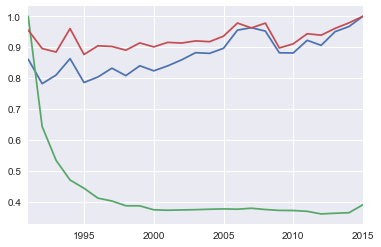

In [4]:
cat =  'Physics, Applied'
p = (cat_pubs_by_year[cat] / cat_pubs_by_year['ALL'])
(p/p.max()).plot()
c = (cat_citations_by_year[cat] / cat_citations_by_year['ALL'])
(c/c.max()).plot()
a = (cat_authors_by_year[cat] / cat_authors_by_year['ALL'])
(a/a.max()).plot()


In [5]:
props = cat_pubs_by_year.divide(cat_pubs_by_year['ALL'],axis=0)
growth = np.log10(props/props.shift(1))

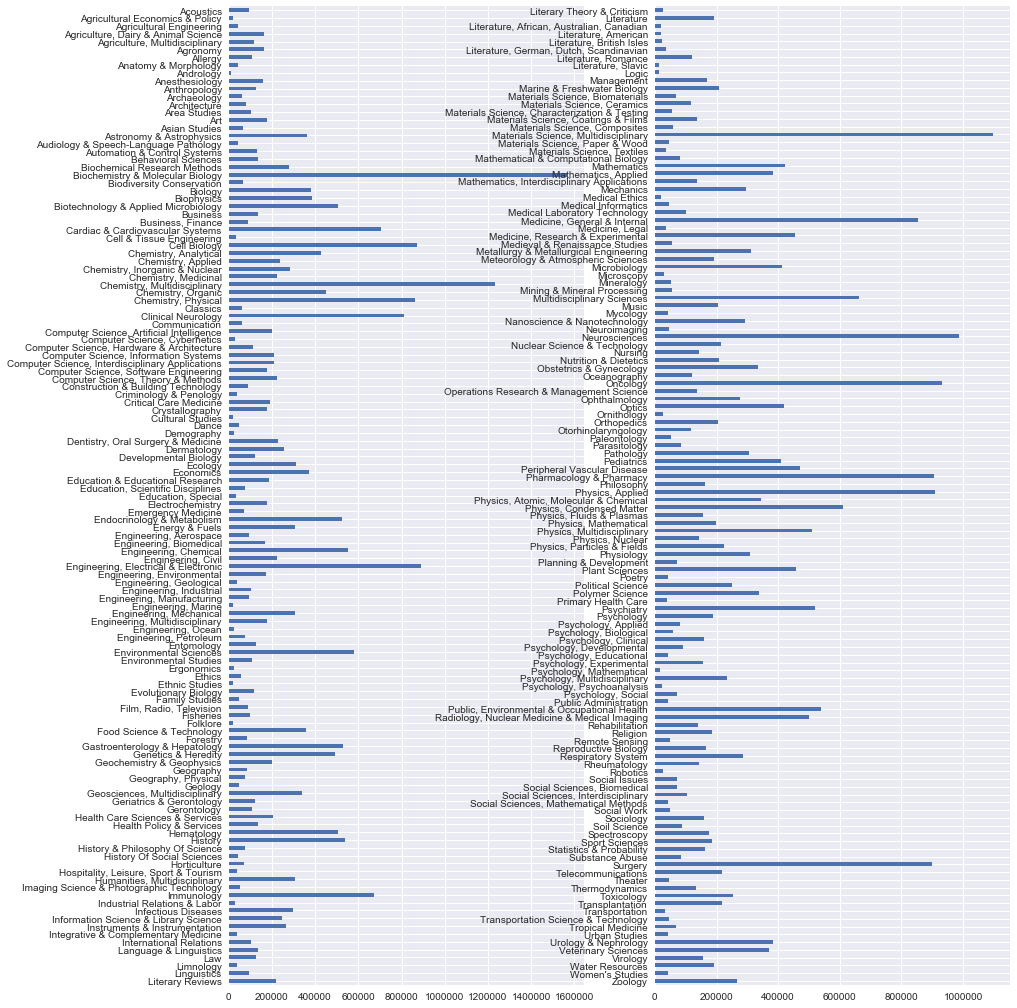

In [6]:
#just a big bar plot of the overall number of pubs for each field
fig,axes = plt.subplots(1,2,figsize=(14,18))
mx = cat_pubs_by_year.sum(0)[:-1].max()
cat_pubs_by_year.sum(0)[:125][::-1].plot(kind='barh',ax=axes[0],ylim=(0,mx))
cat_pubs_by_year.sum(0)[125:-1][::-1].plot(kind='barh',ax=axes[1],ylim=(0,mx));

In [7]:
def growth(cat,window):
    mx = len(cat_pubs_by_year)-(2*window-1)
    result = []
    for i in range(mx):
        a = cat_pubs_by_year[cat][i:i+window].sum()
        aprop = a/cat_pubs_by_year['ALL'][i:i+window].sum()
        b = cat_pubs_by_year[cat][i+window:i+window*2].sum()
        bprop = b/cat_pubs_by_year['ALL'][i+window:i+window*2].sum()
        result.append(np.log(bprop/aprop))    
    return np.array(result)

In [8]:
def parse_results(fi):
    df =  pd.read_table(fi,header=None,names=['measure','data'],index_col='measure')
    df.data = df.data.apply(lambda x: np.array(x.split(','),dtype=float))
    return df

In [11]:
colors = seaborn.color_palette()
def plotter(cat,window_size,mode='local'):
    df = parse_results("{}by-cat-results/{}_null/results_{}_{}".format(DATADIR,mode,window_size,cat))
    start = 1991+window_size-.5
    if mode == 'fixed':
        r = np.arange(start,start+len(df.ix['jsd_m'][0]))
        if window_size%2==0:
            r2 = np.arange(1991,1991+len(df.ix['ent_m'][0]))
        else:
            r2 = np.arange(start,start+len(df.ix['ent_m'][0]))

    else:
        r = np.arange(start,start+len(df.ix['jsds'][0]))
        if window_size%2==0:
            r2 = np.arange(1991,1991+len(df.ix['ents'][0]))
        else:
            r2 = np.arange(start,start+len(df.ix['ents'][0]))

    fig,axes = plt.subplots(1,4,figsize=(16,4))

    if mode == 'fixed':
        ax = axes[1]
        ax.plot(r2,df.ix['ent_m'][0],label='H')
        ax.fill_between(r2,df.ix['ent_m'][0]-df.ix['ent_c'][0],df.ix['ent_m'][0]+df.ix['ent_c'][0],alpha=.25)
        ax.set_title('Entropy')
        ax.legend(loc='lower right')

        ax = axes[3]
        ax.plot(r,df.ix['jsd_m'][0],label='JSD ',color=colors[0])
        ax.fill_between(r,df.ix['jsd_m'][0]-df.ix['jsd_c'][0],df.ix['jsd_m'][0]+df.ix['jsd_c'][0],alpha=.25)
        ax.plot(r,df.ix['ent_dif_m'][0],label=r'$\Delta H$ ',color=colors[1])
        ax.fill_between(r,df.ix['ent_dif_m'][0]-df.ix['ent_dif_c'][0],df.ix['ent_dif_m'][0]+df.ix['ent_dif_c'][0],alpha=.25,color=colors[1])
        ax.legend(loc='upper right')
        ax.set_xticks(np.arange(r[0]-.5,r[-1]+.5,5))    
        ax.set_title('Corrected measures')

    else:
        ax = axes[0]
        ax.plot(r,df.ix['jsds'][0],label='JSD (raw)',color=colors[0])
        ax.plot(r,df.ix['ent_difs'][0],label=r'$\Delta H$ (raw)',color=colors[1])
        ax.plot(r,df.ix['jsd-null_m'][0],label='JSD (null)',c=colors[0],ls='--')
        ax.plot(r,df.ix['entdif-null_m'][0],label=r'$\Delta H$ (null)',color=colors[1],ls='--')
        #ax.fill_between(r,df.ix['entropy-null_m'][0]+df.ix['entropy-null_c'][0],df.ix['entropy-null_m'][0]-df.ix['entropy-null_c'][0],color=colors[1],alpha=.25)
        ax.axhline(0,c='k',ls='--')
        ax.set_xticks(np.arange(r[0]-.5,r[-1]+.5,5))
        ax.legend(loc='lower right',fontsize='medium')
        ax.set_title('Change measures')

        ax = axes[1]
        ax.plot(r2,df.ix['ents'][0],label='H (raw)')
        if mode == 'global':
            ax.plot(r2,df.ix['entropy-null_m'][0],label='H (null)',color=colors[1])
            ax.fill_between(r2,df.ix['entropy-null_m'][0]+df.ix['entropy-null_c'][0],df.ix['entropy-null_m'][0]-df.ix['entropy-null_c'][0],color=colors[1],alpha=.25)
        ax.set_title('Entropy')
        ax.legend(loc='lower right')

        ax = axes[3]
        ax.plot(r,df.ix['jsds'][0]-df.ix['jsd-null_m'][0],label='JSD (corrected)',color=colors[0])
        ax.plot(r,df.ix['ent_difs'][0]-df.ix['entdif-null_m'][0],label=r'$\Delta H$ (corrected)',color=colors[1])
        ax.legend(loc='upper right')
        ax.set_xticks(np.arange(r[0]-.5,r[-1]+.5,5))    
        ax.set_title('Corrected measures')

    ax = axes[2]
    ax.plot(r,growth(cat,window_size),label='Growth')
    ax.axhline(0,c='k',ls='--')
    ax.set_xticks(np.arange(r[0]-.5,r[-1]+.5,5))
    ax.set_title('Growth')



    fig.suptitle("{} - {} null".format(cat,mode))
    

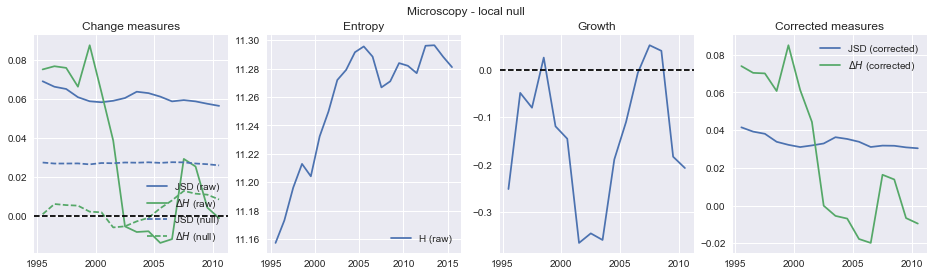

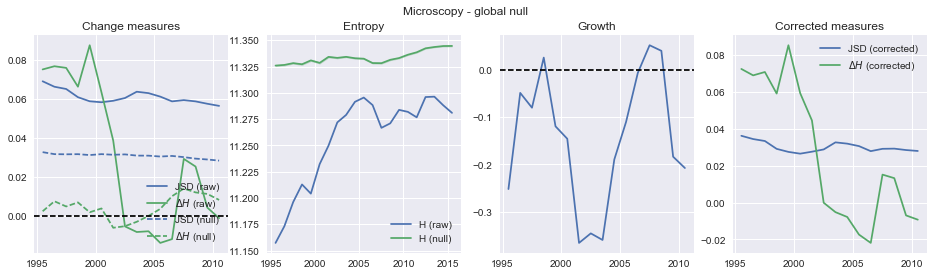

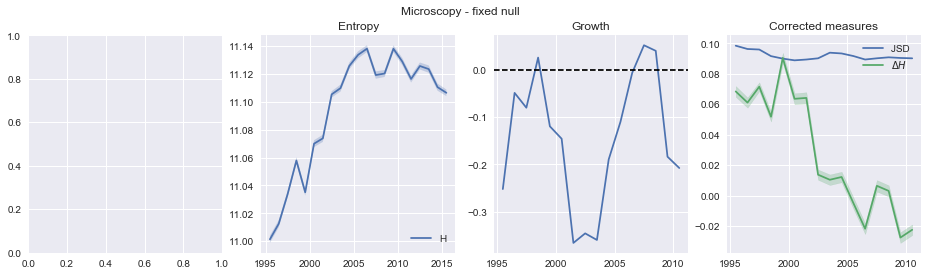

In [16]:
cat = 'Microscopy'
win = 5
plotter(cat,win,'local')
plotter(cat,win,'global')
plotter(cat,win,'fixed')

In [27]:
ent_m = np.array([11.3544823358,11.3741821571,11.3912019033,11.4088411879,11.4235851207,11.4251969262,11.4273789044,11.4301594609,11.4283738167,11.4270117251,11.4304487987,11.4314593202,11.4349793221,11.4409663258,11.4467888116,11.447569328,11.4472383446,11.4456235071,11.4407666646,11.4367084557,11.4323948261])
ent_c =  np.array([0.000488824827895,0.000523603029594,0.000525541265933,0.000504400060889,0.000524845429205,0.000554782941266,0.000590986250294,0.000576179525601,0.000566265069805,0.000528343731186,0.00051291589206,0.000517298209184,0.000551640093075,0.000545686496846,0.000506481058794,0.000472420957657,0.000470152689945,0.000512894048743,0.000505029913478,0.000548591662094,0.000544974999379])
ent_dif_m = np.array([0.0707145904107,0.0531967472416,0.0389575576038,0.0195326287694,0.00342660441061,0.00525187246579,0.004080415818,0.00481986118802,0.012592509098,0.0197770864457,0.0171205293224,0.0157790243758,0.0106441850396,-0.000199661205747,-0.0100803559154,-0.0151745019219])
ent_dif_c = np.array([0.000732680075266,0.000770669669187,0.000771260061773,0.00074635915013,0.000709961586321,0.000755132812358,0.000817273466135,0.000847645720996,0.000826526126895,0.000728660426528,0.000651411766758,0.000651274426075,0.000759075975081,0.000752039912024,0.000784680428243,0.000775425146484])
jsd_m = np.array([0.0327522047362,0.0318061016103,0.0294736193936,0.0275682774265,0.0262456516035,0.0255018698355,0.0251763489252,0.0243728225154,0.0244824342651,0.0244115374192,0.0239800920795,0.023102397033,0.0224466102068,0.0219500577847,0.0215820460802,0.0214227817129])
jsd_c = np.array([4.40691320826e-05,4.31711856786e-05,4.35513154602e-05,4.16838288385e-05,3.82861520879e-05,4.37418943459e-05,4.72133694941e-05,3.75576301241e-05,3.92754764349e-05,4.09837970744e-05,3.96967127377e-05,3.89328613601e-05,3.32344892589e-05,3.88683085954e-05,3.66748086262e-05,3.58651167354e-05])

df_local = parse_results("{}by-cat-results/{}_null/results_{}_{}".format(DATADIR,'local',5,'Neurosciences'))
df_global = parse_results("{}by-cat-results/{}_null/results_{}_{}".format(DATADIR,'global',5,'Neurosciences'))

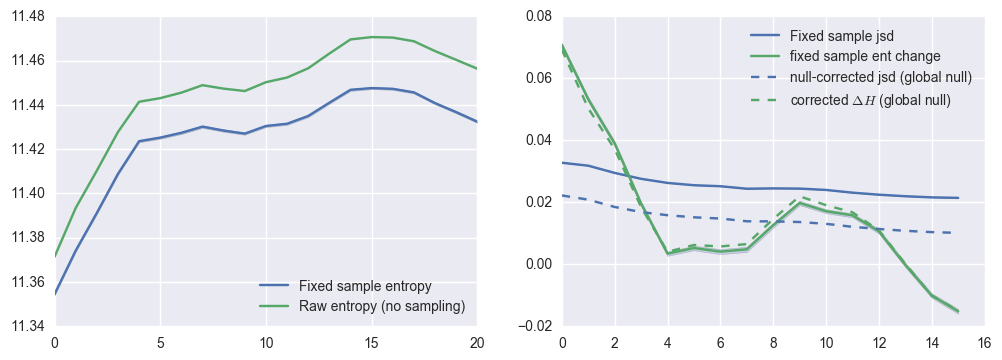

In [43]:
fig,axes = plt.subplots(1,2,figsize=(12,4))
ax = axes[0]
ax.plot(ent_m,label='Fixed sample entropy')
ax.fill_between(range(len(ent_m)),ent_m-ent_c,ent_m+ent_c,alpha=.25)
ax.plot(df_global.ix['ents']['data'],label='Raw entropy (no sampling)')
ax.legend(loc='lower right')
ax = axes[1]
ax.plot(jsd_m,label='Fixed sample jsd')
ax.fill_between(range(len(jsd_m)),jsd_m-jsd_c,jsd_m+jsd_c,alpha=.25)
ax.plot(ent_dif_m,label='fixed sample ent change')
ax.fill_between(range(len(ent_dif_m)),ent_dif_m-ent_dif_c,ent_dif_m+ent_dif_c,alpha=.25)
ax.plot(df_global.ix['jsds'][0]-df_global.ix['jsd-null_m'][0],label='null-corrected jsd (global null)',color=colors[0],ls='--')
#ax.plot(df_local.ix['jsds'][0]-df_local.ix['jsd-null_m'][0],label='null-corrected jsd (local null)',color=colors[0],ls='--')
ax.plot(df_global.ix['ent_difs'][0]-df_global.ix['entdif-null_m'][0],label=r'corrected $\Delta H$ (global null)',color=colors[1],ls='--')
#ax.plot(df_local.ix['ent_difs'][0]-df_local.ix['entdif-null_m'][0],label=r'corrected $\Delta H$ (global null)',color=colors[1],ls='-',lw=.5)

ax.legend()

In [24]:
df_global

,data
measure,
ents,"[11.2935021922, 11.3041780128, 11.3047106979, ..."
ent_difs,"[0.0106758206411, 0.000532685076811, 0.0189275..."
jsds,"[0.0218432274225, 0.0216242247396, 0.023442963..."
entropy-null_m,"[11.4736046936, 11.4762918362, 11.4775776191, ..."
entropy-null_c,"[0.000402575078975, 0.00042374488511, 0.000392..."
entdif-null_m,"[0.00268714263071, 0.00128578282943, 0.0027204..."
entdif-null_c,"[0.000563943003046, 0.000592850199706, 0.00056..."
jsd-null_m,"[0.0159214447273, 0.0152496489151, 0.014464729..."
jsd-null_c,"[1.47810220753e-05, 1.39152363935e-05, 1.15661..."


In [14]:
df_local

,data
measure,
ents,"[11.2935021922, 11.3041780128, 11.3047106979, ..."
ent_difs,"[0.0106758206411, 0.000532685076811, 0.0189275..."
jsds,"[0.0218432274225, 0.0216242247396, 0.023442963..."
entdif-null_m,"[0.00114243120832, 0.00111919936972, 0.0017730..."
entdif-null_c,"[0.000533989545755, 0.000579123987826, 0.00055..."
jsd-null_m,"[0.0104151076744, 0.010010433051, 0.0097667458..."
jsd-null_c,"[1.46022370797e-05, 1.11939231353e-05, 1.71707..."


In [87]:

pd.Series(np.random.zipf(2,500)).value_counts().add(pd.Series(np.random.zipf(2,500)).value_counts(),fill_value=0)

1       611.0
2       156.0
3        69.0
4        37.0
5        16.0
6        18.0
7        12.0
8        11.0
9         8.0
10        7.0
11        6.0
12        3.0
13        5.0
14        6.0
15        2.0
16        4.0
17        2.0
18        2.0
19        3.0
20        1.0
21        1.0
25        1.0
28        1.0
29        1.0
30        1.0
34        1.0
40        1.0
46        1.0
47        2.0
52        1.0
54        1.0
59        1.0
61        1.0
63        1.0
92        1.0
105       1.0
112       1.0
123       1.0
147       1.0
1178      1.0
dtype: float64

In [152]:
def sampler(orig_docs,sample_size):
    docs = []
    # generate `orig_docs` from a zipf distribution
    for _ in range(orig_docs):
        # this just creates a freq distribution of words for each doc
        docs.append(pd.Series(np.random.zipf(2,500)).value_counts())
    # now sample a number `sample_size` from these docs
    sample = np.random.choice(docs,sample_size,replace=False)
    # now put the sampled docs together and generate the overall word distribution
    concat = pd.concat(docs)
    result = concat.groupby(concat.index).sum()
    return result / result.sum()

In [153]:
from tqdm import tqdm_notebook as tq
def jsd(p,q):
    return entropy((p+q)/2.,base=2) - 0.5*entropy(p,base=2) - 0.5*entropy(q,base=2)
h1 = []
h2 = []
for _ in tq(range(2000)):
    dist1 = sampler(1000,500)
    dist2 = sampler(2000,500)
    h1.append(entropy(dist1,base=2))
    h2.append(entropy(dist2,base=2))


KeyboardInterrupt: 

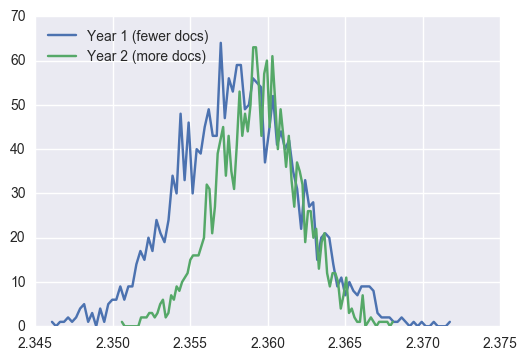

In [138]:
fig,ax = plt.subplots(1,1)
vals,bins = np.histogram(h1,bins=100)
ax.plot(bins[:-1],vals,label='Year 1 (fewer docs)')
vals,bins = np.histogram(h2,bins=100)
ax.plot(bins[:-1],vals,label='Year 2 (more docs)')
ax.legend(loc='upper left')

In [139]:
from scipy.stats import ks_2samp
ks_2samp(h1,h2)

Ks_2sampResult(statistic=0.19549999999999998, pvalue=6.9755790583782831e-34)

In [157]:
from tqdm import tqdm_notebook as tq
def jsd(p,q):
    return entropy((p+q)/2.,base=2) - 0.5*entropy(p,base=2) - 0.5*entropy(q,base=2)
h1 = []
h2 = []
for _ in tq(range(1000)):
    dist1 = sampler(500,250)
    dist2 = sampler(1000,250)
    h1.append(entropy(dist1,base=2))
    h2.append(entropy(dist2,base=2))


KeyboardInterrupt: 

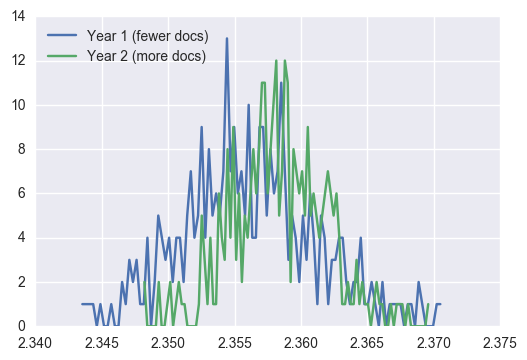

In [158]:
fig,ax = plt.subplots(1,1)
vals,bins = np.histogram(h1,bins=100)
ax.plot(bins[:-1],vals,label='Year 1 (fewer docs)')
vals,bins = np.histogram(h2,bins=100)
ax.plot(bins[:-1],vals,label='Year 2 (more docs)')
ax.legend(loc='upper left')

In [159]:
ks_2samp(h1,h2)

Ks_2sampResult(statistic=0.27492447129909364, pvalue=1.6503214806228301e-11)

In [151]:
np.random.choice?